In [79]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# Random Forest Feature Importance on Breast Cancer Data

In [80]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Load data
data = pd.read_csv('breast-cancer-wisconsin-updated.csv')

# Replace '?' with NaN
data = data.replace('?', np.nan)

# Convert columns to numeric
data = data.apply(pd.to_numeric)

# Replace NaN with mean values
data = data.fillna(data.mean())

# Split data into X and y
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train decision tree classifier and perform cost complexity pruning
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))


Accuracy on test data: 0.96


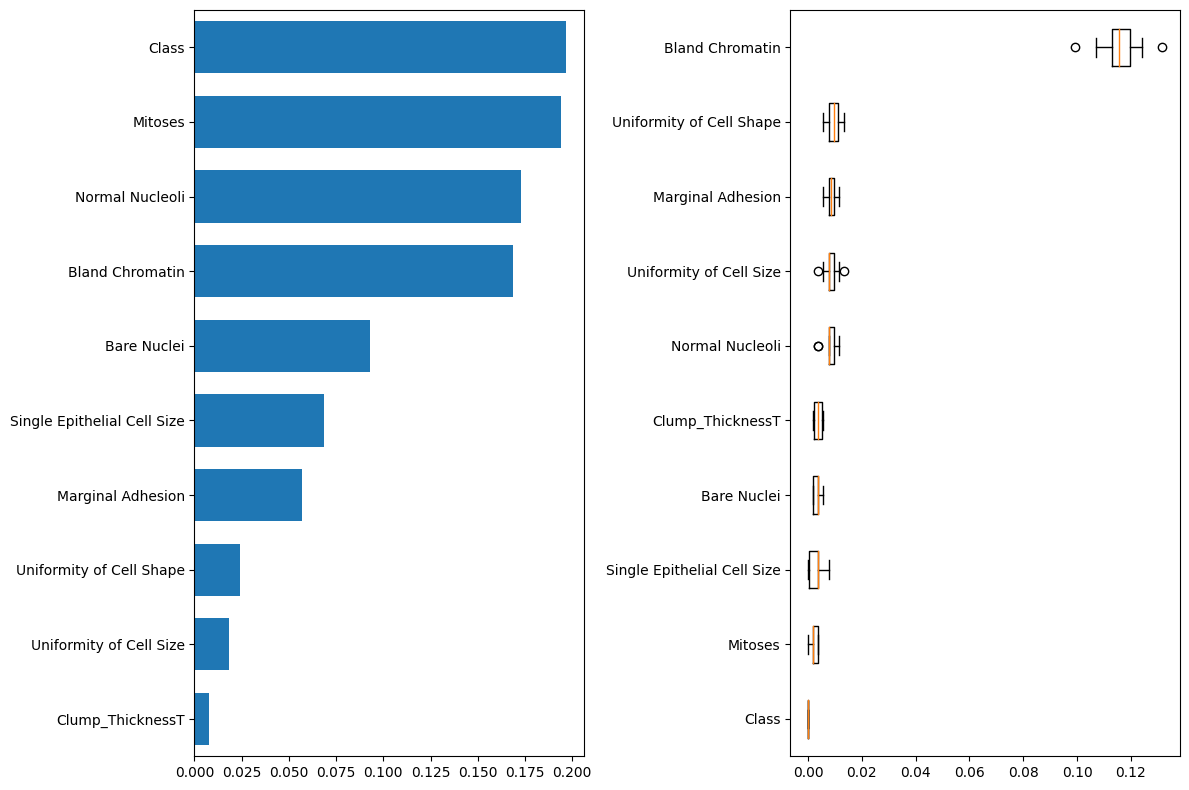

In [81]:
result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

# Sort the feature importances calculated from the tree-based model
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(['Clump_ThicknessT', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class'])
ax1.set_ylim((0, len(clf.feature_importances_)))

labels = np.array(['Clump_ThicknessT', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class'])
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=labels[perm_sorted_idx],
)
fig.tight_layout()
plt.show()


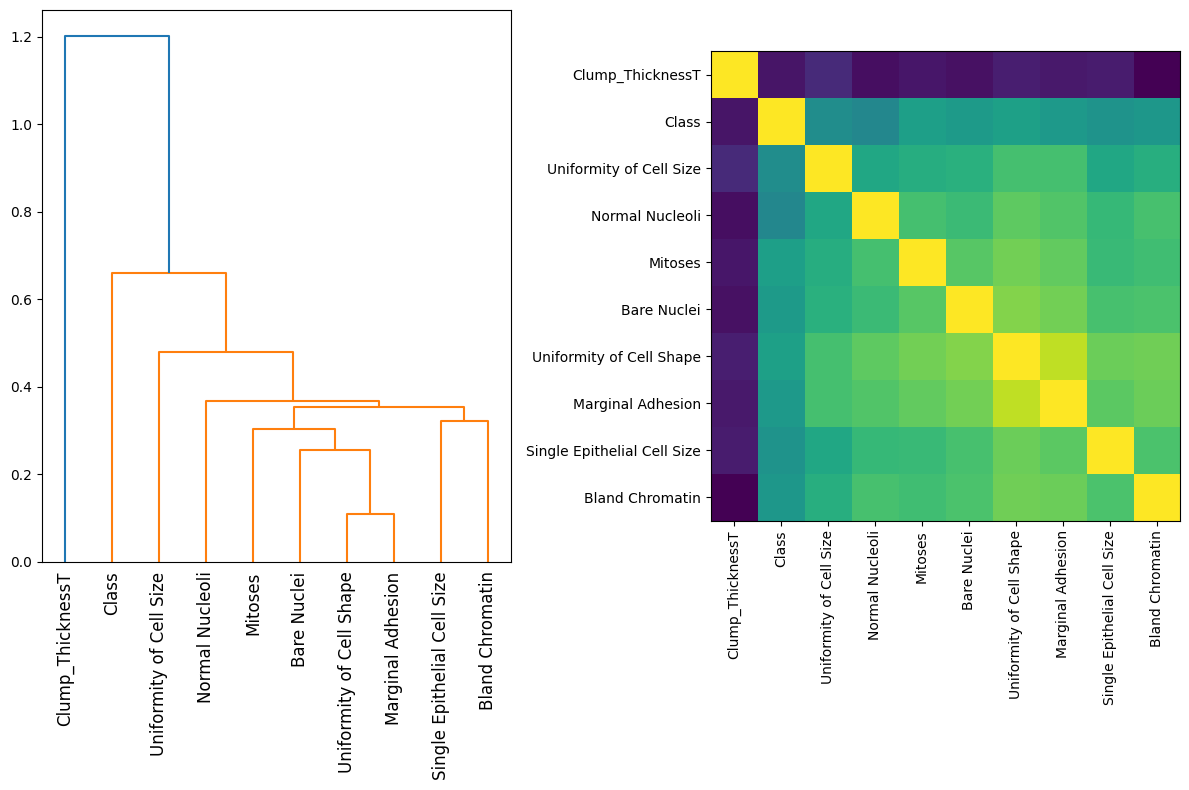

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=np.array(['Clump_ThicknessT', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']).tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()


In [83]:
cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [(i,) for i in [v[0] for v in cluster_id_to_feature_ids.values()]]

# Select features to keep and train a new random forest
X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]
clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)

# Print accuracy on test data with features removed
print("Accuracy on test data with features removed: {:.2f}".format(clf_sel.score(X_test_sel, y_test)))


TypeError: '(slice(None, None, None), [(0,), (1,)])' is an invalid key